# Stereo Vision



## Import Modules

In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import scipy.signal
import scipy.linalg
import mae6292.tools as mae6292
import importlib

from mae6292.imshow import cv2_imshow

## Load Image 

We again utilize [KITTI dataset](http://www.cvlibs.net/datasets/kitti/). The images are already undistored and rectified. We further scale the images into half for speedup.

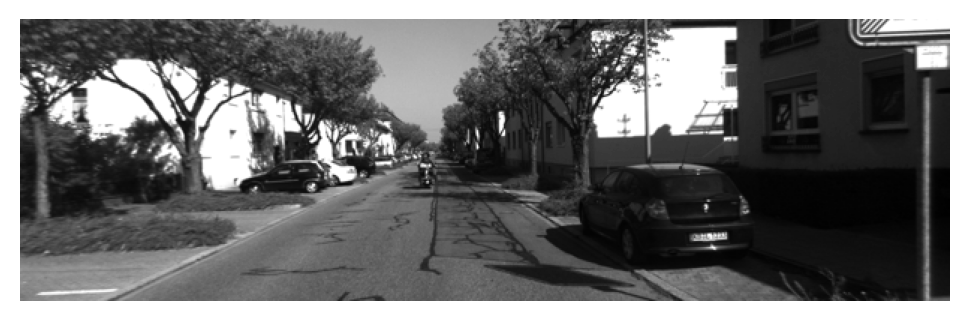

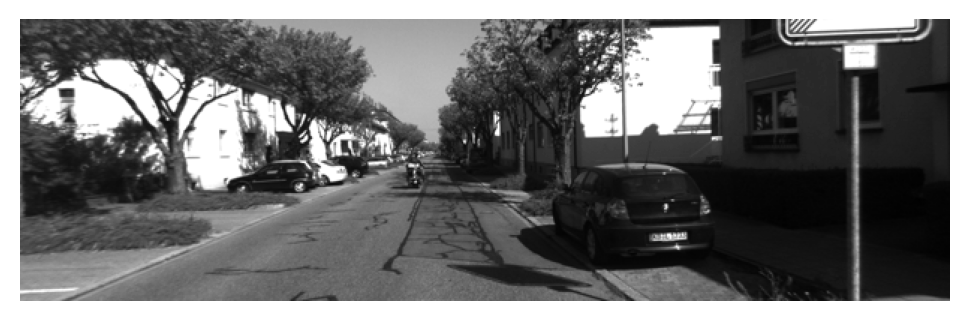

In [22]:
# resize_factor = 0.5
# img_left = cv2.resize(cv2.imread('data/left/000000.png',cv2.IMREAD_GRAYSCALE), None, fx=resize_factor, fy=resize_factor)
# img_right = cv2.resize(cv2.imread('data/right/000000.png',cv2.IMREAD_GRAYSCALE), None, fx=resize_factor, fy=resize_factor)

img_left = cv2.imread('data/left/h000000.png', cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread('data/right/h000000.png', cv2.IMREAD_GRAYSCALE)

cv2_imshow(img_left)
cv2_imshow(img_right)


# Disparity

We impose a bound on the disparity:

$$ d_{\min} \leq u_{left} - u_{right} \leq d_{\max},$$

where 
* the lower bound means we do not want to consider the objects too far;
* and the upper bound means we do not want to consider the objects too close.

Also, this reduces the search space on the right image, as

$$ u_{left}-d_{\max} \leq u_{right} \leq u_{left}-d_{\min}.$$


In [23]:
baseline = 0.54 # copied from KITTI data set
W_patch = 5
d_min = 5
d_max = 50



We extract the image patch on the left, and the corresponding image strip from the right satisfying the above inequality for $u_{right}$. The strip is padded by $W$ both left and right. Consequently, the size of right strip is $d_{\max}-d_{\min}+2W+1$

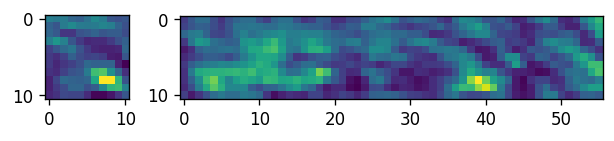

In [24]:
N_rows, N_cols = img_left.shape
disparity = np.zeros((N_rows,N_cols))

# the first patch on the upper left corner
i_row = W_patch
i_col = W_patch+d_max
patch_left = img_left[i_row-W_patch:i_row+W_patch+1, i_col-W_patch:i_col+W_patch+1]

# extract strip from the right image satisfying the about inequality
strip_right = img_right[i_row-W_patch:i_row+W_patch+1, i_col-W_patch-d_max:i_col+W_patch-d_min+1]

fig, axes = plt.subplots(1, 2, dpi=120, figsize=(6,6), gridspec_kw={'width_ratios': [1, 5]})
axes[0].imshow(patch_left)
axes[1].imshow(strip_right)


To compare the distance between the patch of the left, and all of the possible patches from the right image are reshaped into column vectors. We can extract $d_{\max}-d_{\min} +1$ patches from the strip.

Then, as we did in Harris feature matching, `patch_left` is rearranged into a column, we compute SSD with

```
SSD = scipy.spatial.distance.cdist(patch_left.T, patches_right.T, 'sqeuclidean')
```
The location `i_match` with the min SSD corresponds to the match. Note that for `patch_left` centered at `i_col`, the first patch from `strip_right` is centered at `i_col-d_max`. As such, the column `i_match` in the `patches_right` corresponds to `i_col - d_max + i_match` in the right image. Therefore, the disparity is `i_col - (i_col - d_max + i_match) = d_max - i_match`

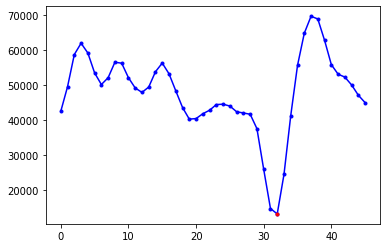

In [25]:
# reshape patch and strip into columns
patch_left = np.reshape( patch_left, ((2*W_patch+1)**2,1), order='F')
patches_right = np.zeros( ((2*W_patch+1)**2,  d_max-d_min+1) ) 

for i in range(2*W_patch+1):
    patches_right[i*(2*W_patch+1):(i+1)*(2*W_patch+1), :] = strip_right[:, i:(i+d_max-d_min+1)]

# compute SSD for all of possible patches from the strip
SSD = scipy.spatial.distance.cdist(patch_left.T, patches_right.T, 'sqeuclidean').flatten()
i_match = np.argmin(SSD)

# the index in the strip should be converted back to the image so that the disparity is given by
disparity[i_row, i_col] = d_max-i_match

plt.plot(range(d_max-d_min+1),SSD,'.b-')
plt.plot(i_match, SSD[i_match], 'r.')


The above procedure is repeated for every pixel in the left image.

In [26]:
def compute_disparity(img_left, img_right, W_patch, d_min, d_max):
    N_rows, N_cols = img_left.shape
    disparity = np.zeros((N_rows,N_cols))

    for i_row in range(W_patch, N_rows-W_patch):
        for i_col in range(W_patch+d_max, N_cols-W_patch):
            
            patch_left = img_left[i_row-W_patch:i_row+W_patch+1, i_col-W_patch:i_col+W_patch+1]
            strip_right = img_right[i_row-W_patch:i_row+W_patch+1, i_col-W_patch-d_max:i_col+W_patch-d_min+1]

            patch_left = np.reshape( patch_left, ((2*W_patch+1)**2,1), order='F')
            patches_right = np.zeros( ((2*W_patch+1)**2,  d_max-d_min+1) ) 

            for i in range(2*W_patch+1):
                patches_right[i*(2*W_patch+1):(i+1)*(2*W_patch+1), :] = strip_right[:, i:(i+d_max-d_min+1)]

            SSD = scipy.spatial.distance.cdist(patch_left.T, patches_right.T, 'sqeuclidean').flatten()
            i_match = np.argmin(SSD)

            disparity[i_row, i_col] = d_max-i_match

    return disparity

In [27]:
disparity = compute_disparity(img_left, img_right, W_patch, d_min, d_max)

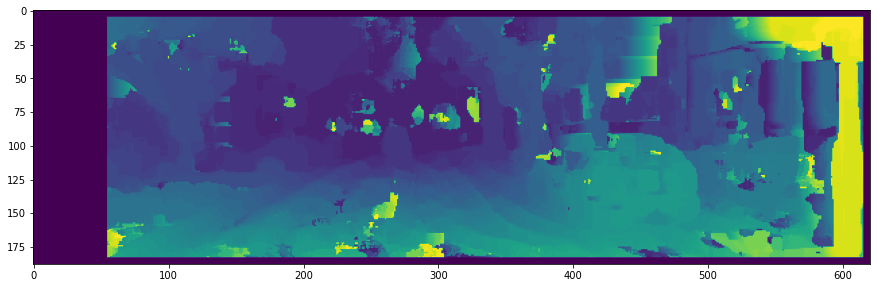

In [28]:
plt.figure(figsize=(15,5))
plt.imshow(disparity)

## Outlier Removal

However, as illustrated above, the diparity contains many outliers, or yellow blobs. This implies that the match may not be a good one, even if it minimizes SSD. 

1. We reject a match if there are more than two SSDs less than or equal to 1.5 times of the min SSD. This is similar with the ratio test of SIFT. Since it is likely that the min SSD is located between two pixels (see the above SSD plot), we require more than two within the range to discard it. 
2. We also ignore the matches at the edge of `strip_right`

In [29]:

N_rows, N_cols = img_left.shape
disparity = np.zeros((N_rows,N_cols))

for i_row in range(W_patch, N_rows-W_patch):
    for i_col in range(W_patch+d_max, N_cols-W_patch):


        patch_left = img_left[i_row-W_patch:i_row+W_patch+1, i_col-W_patch:i_col+W_patch+1]
        strip_right = img_right[i_row-W_patch:i_row+W_patch+1, i_col-W_patch-d_max:i_col+W_patch-d_min+1]

        patch_left = np.reshape( patch_left, ((2*W_patch+1)**2,1), order='F')
        patches_right = np.zeros( ((2*W_patch+1)**2,  d_max-d_min+1) ) 

        for i in range(2*W_patch+1):
            patches_right[i*(2*W_patch+1):(i+1)*(2*W_patch+1), :] = strip_right[:, i:(i+d_max-d_min+1)]

        SSD = scipy.spatial.distance.cdist(patch_left.T, patches_right.T, 'sqeuclidean').flatten()
        i_match = np.argmin(SSD)
        SSD_min = SSD[i_match]
        
            
        if SSD[SSD <= SSD_min*1.5].shape[0] < 3 and i_match != 0 and i_match != SSD.shape[0]-1:
            disparity[i_row, i_col] = d_max-i_match

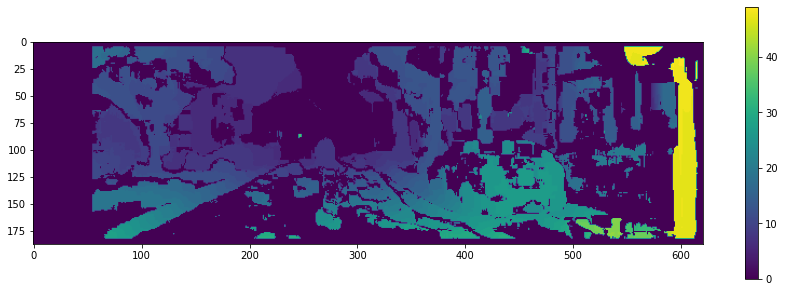

In [30]:
plt.figure(figsize=(15,5))
plt.imshow(disparity)
plt.colorbar()


## Sub-pixel Refinements

As discussed above, it is likely that the min of SSD appear between two pixels. Once the mininum SSD is found, we can fit the SSD using a second order polynomial using the neighboring values. More specifically, we have the data
```
[i_match-1, i_match, i_match+1], SSD[[i_match-1, i_match, i_match+1]]
```
to approximate the SSD with
$$
SSD(i) = p_0 i^2 + p_1 i + p_2.
$$
Then, the value of $i$ minimizing $SSD$ is given by
$$
i^* = -\frac{p_1}{2p_0}
$$
This has been implemented by
```
disparity = mae6292.compute_disparity(img_left, img_right, W_patch, d_min, d_max)
```

In [31]:
importlib.reload(mae6292)
W_patch = 5
d_min = 5
d_max = 50
disparity = mae6292.compute_disparity(img_left, img_right, W_patch, d_min, d_max)

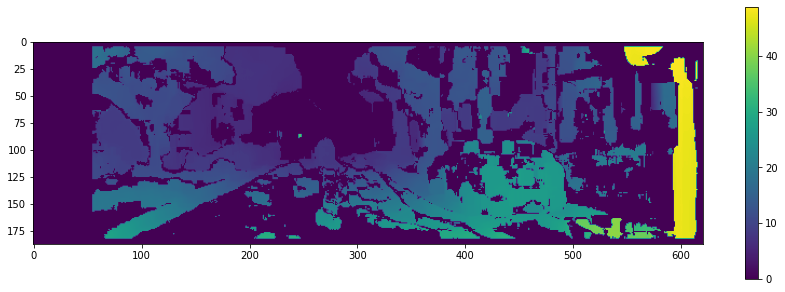

In [32]:
plt.figure(figsize=(15,5))
plt.imshow(disparity)
plt.colorbar()

## Triangulation

Recall
\begin{align*}
\lambda_1 \begin{bmatrix} u_1 \\ v_1 \\ 1\end{bmatrix} = K_1[I_{3\times 3}|0] P\\
\lambda_2 \begin{bmatrix} u_2 \\ v_2 \\ 1\end{bmatrix} = K_2[R|T] P
\end{align*}
Since the images are already rectified with $\bar R=I_{3\times 3}$ and $\bar K = K_1 = K_2$, we have $T=[-b, 0, 0]$ and
\begin{align*}
\lambda_1 \begin{bmatrix} u_1 \\ v_1 \\ 1\end{bmatrix} = \lambda_1 p_1 = \bar K[I_{3\times 3}|0] P = M_1 P \\
\lambda_2 \begin{bmatrix} u_2 \\ v_2 \\ 1\end{bmatrix} = \lambda_2 p_2 = \bar K[I_{3\times 3}|T] P = M_2 P
\end{align*}

As discussed in class, $P\in\Re^{4}$ belongs to the null space of
\begin{align*}
\begin{bmatrix} \hat p_1 M_1 \\ \hat p_2 M_2 \end{bmatrix}
\end{align*}

The homogeneous coordinate $P$ can be converted to $3\times 1$ position vector $[X_w,Y_w,Z_w]$. The sign ambiguity of the null space can be resolved by requiring that $Z_w > 0$.

In [33]:
importlib.reload(mae6292)

# KITTI data
K = np.array([[359.4280, 0, 303.5964],
    [0,  359.4280,   92.6078],
    [0, 0, 1]])

P, P_intensity = mae6292.disparity2PC(disparity, K, baseline, img_left)


/var/folders/4c/9t8rp6b56glc071r5m4yvfph0000gn/T/ipykernel_21727/3162740822.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


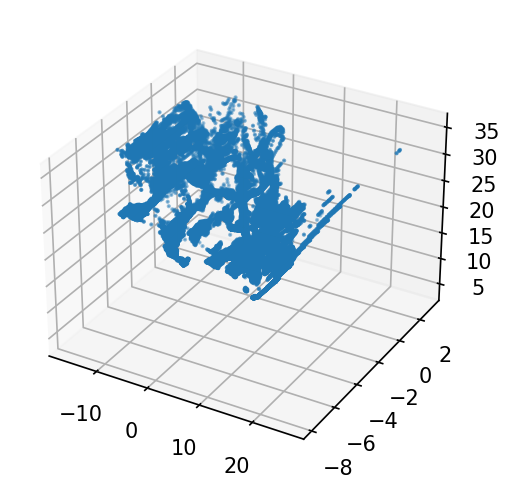

In [34]:
fig = plt.figure(dpi=150)

ax = fig.gca(projection='3d')
ax.scatter(P[0,:],P[1,:],P[2,:], s =1 )


The resulting point clouds can be saved into a [PLY file](https://en.wikipedia.org/wiki/PLY_(file_format)), so that it can be opened by [MeshLab](https://www.meshlab.net)

In [ ]:
filename = 'point_clouds.ply'
file_header = ['ply\n', 'format ascii 1.0\n',\
               'element vertex '+str(P.shape[1])+'\n',\
               'property double x\n', 'property double y\n', 'property double z\n',\
               'property uchar red\n', 'property uchar green\n', 'property uchar blue\n',\
               'end_header\n']

P_intensity = np.reshape(P_intensity, (1,-1))
DATA = np.concatenate((P, P_intensity, P_intensity, P_intensity), axis=0)

with open(filename,'w') as f:
    f.writelines(file_header)

with open(filename, 'a') as f:
    np.savetxt(f, DATA.T, fmt='%1.4f %1.4f %1.4f %i %i %i')

The above procedure can be repeated to generate a 3D scene of point clound as illustrated below. (Caution: the next cell of code may take a long time to complete)

![](3D_scene_0.png)
![](3D_scene_1.png)

In [ ]:
importlib.reload(mae6292)

W_patch = 5
d_min = 5
d_max = 50
K = np.array([[359.4280, 0, 303.5964],
    [0,  359.4280,   92.6078],
    [0, 0, 1]])

R_CW = np.array([[0, -1, 0], [0, 0, -1], [1, 0, 0]]);
T_CW = np.zeros((4,4))
T_CW[0:3,0:3]=R_CW
T_CW[3,3]=1

pose = np.loadtxt('data/poses.txt')
P_all = np.empty((3,0))
Intensity_all = np.empty((1,0))

resize_factor = 0.5

for k in range(100):
    filename = "{:06d}.png".format(k)   
    
    img_left = cv2.imread('data/left/'+filename, cv2.IMREAD_GRAYSCALE)
    img_left = cv2.resize(img_left, None, fx=resize_factor, fy=resize_factor)
    img_right = cv2.imread('data/right/'+filename, cv2.IMREAD_GRAYSCALE)
    img_right = cv2.resize(img_right, None, fx=resize_factor, fy=resize_factor)
    
    disparity = mae6292.compute_disparity(img_left, img_right, W_patch, d_min, d_max)
    P_C, intensity = mae6292.disparity2PC(disparity, K, baseline, img_left)
    P_W = R_CW.T@P_C
    T_W_F = pose[k,:].reshape(3,4) @ T_CW
    P = T_W_F[0:3,0:3]@P_W + T_W_F[:,[3]]*np.ones((1, P_C.shape[1]))
    P_all = np.append(P_all, P, axis=1)
    Intensity_all = np.append(Intensity_all, intensity, axis=1)


In [ ]:
filename = 'point_clouds_99.ply'
file_header = ['ply\n', 'format ascii 1.0\n',\
               'element vertex '+str(P_all.shape[1])+'\n',\
               'property double x\n', 'property double y\n', 'property double z\n',\
               'property uchar red\n', 'property uchar green\n', 'property uchar blue\n',\
               'end_header\n']


DATA = np.concatenate((P_all, Intensity_all, Intensity_all, Intensity_all), axis=0)


with open(filename,'w') as f:
    f.writelines(file_header)

with open(filename, 'a') as f:
    np.savetxt(f, DATA.T, fmt='%1.4f %1.4f %1.4f %i %i %i')
    
    
    